# RGB-Thermal Image Fusion
This notebook demonstrates two different methods for **RGB-Thermal image fusion** using Python.
1. **Enhanced Correlation Coefficient (ECC) using OpenCV**  
   - Robust alignment for global motion  
   - Fusion step is non-adaptive

2. **SimpleITK registration framework**  
    - Designed for multimodal image registration
    - High precision alignment

## Fusion Method 1: ECC-Based Alignment and Fusion
This method performs image registration using the **Enhanced Correlation Coefficient (ECC)** algorithm from OpenCV to align the thermal and RGB images.

ECC correlation coefficient: 0.615822136706069
SSIM: 0.4280


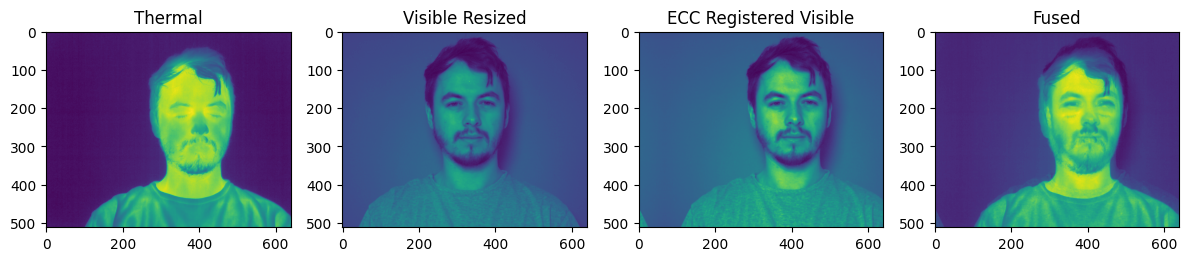

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# ==== 1. Load images ====
visible_file = 'u130vswir\\frameblock_00000.npy'  # Replace with actual path
thermal_file = 'boson\\video.npy'

visible_data = np.load(visible_file)
thermal_data = np.load(thermal_file)

visible_frame = visible_data[4, 65:900, 50:1100, 0]  # uint8, (1032, 1296) data[59, 60:900, 50:1100, 0]
thermal_frame = thermal_data[4]

# Normalize thermal to uint8 and then to float32
thermal_uint8 = cv2.normalize(thermal_frame, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
thermal_norm = thermal_uint8.astype('float32') / 255.0

# Resize visible to thermal size and normalize
visible_scaled = visible_resized = cv2.resize(visible_frame, (640, 512), interpolation=cv2.INTER_LINEAR) #cv2.INTER_AREA
# vh, vw = visible_scaled.shape
# start_y = (vh - 512) // 2
# start_x = (vw - 640) // 2
# visible_resized = visible_scaled[start_y:start_y+512, start_x:start_x+640]


# Normalize for ECC
visible_norm = visible_resized.astype('float32') / 255.0

# ==== 2. ECC Registration ====
warp_matrix = np.eye(2, 3, dtype=np.float32)  # Affine transform

criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 500, 1e-6)

try:
    cc, warp_matrix = cv2.findTransformECC(
        templateImage=thermal_norm, # thermal_norm
        inputImage=visible_norm,  #visible_norm
        warpMatrix=warp_matrix,
        motionType=cv2.MOTION_TRANSLATION, # cv2.MOTION_AFFINE, cv2.MOTION_TRANSLATION, cv2.MOTION_HOMOGRAPHY
        criteria=criteria
    )
    print("ECC correlation coefficient:", cc)

    # Warp the visible image to align with thermal
    aligned_visible = cv2.warpAffine(visible_resized,
                                     warp_matrix, (640, 512), 
                                     flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP,
                                     borderMode=cv2.BORDER_REFLECT)
    
except cv2.error as e:
    print("ECC registration failed:", e)
    aligned_visible = visible_resized  # fallback

# ==== 3. Evaluate SSIM ====
ssim_score, _ = ssim(thermal_uint8, aligned_visible, full=True)
print(f"SSIM: {ssim_score:.4f}")
# ==== 3. Fusion ====
fused = cv2.addWeighted(thermal_uint8, 0.5, aligned_visible.astype('uint8'), 0.5, 0)

# ==== 4. Display ====
titles = ['Thermal', 'Visible Resized', 'ECC Registered Visible', 'Fused']
images = [thermal_uint8, visible_resized, aligned_visible, fused]

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(images[i])
    plt.title(titles[i])
    # plt.axis('off')
plt.tight_layout()
plt.show()


## Fusion Method 2: SimpleITK registration framework

This method uses **SimpleITK**, a powerful image processing library, to perform multimodal image registration.


Visible frame shape: (835, 1050) data type: uint8
Thermal frame shape: (512, 640) data type: uint16
Registration complete.
Final Transform:
 itk::simple::CompositeTransform
 CompositeTransform (000002A4ED9EE0F0)
   RTTI typeinfo:   class itk::CompositeTransform<double,2>
   Reference Count: 1
   Modified Time: 13826
   Debug: Off
   Object Name: 
   Observers: 
     none
   TransformQueue: 
   >>>>>>>>>
   AffineTransform (000002A4ED4F1DA0)
     RTTI typeinfo:   class itk::AffineTransform<double,2>
     Reference Count: 1
     Modified Time: 13816
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       0.616498 0.00188675 
       -0.00984345 0.605442 
     Offset: [48.9506, 25.5935]
     Center: [515.52, 459.676]
     Translation: [-147.885, -160.85]
     Inverse: 
       1.62198 -0.00505462 
       0.0263707 1.6516 
     Singular: 0
   TransformsToOptimizeFlags: 
           1 
   TransformsToOptimizeQueue: 
   PreviousTransformsToOptimizeUpdateTime: 0


 -

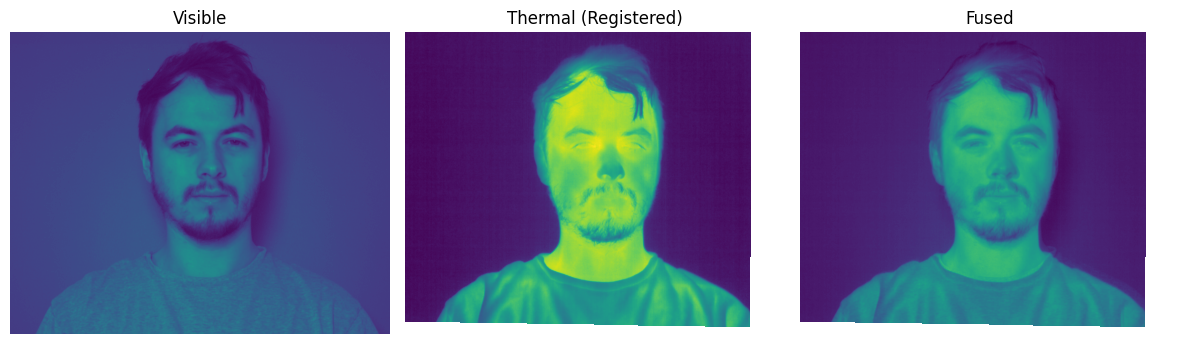

In [ ]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

# Load data
visible_file = 'u130vswir\\frameblock_00000.npy'
thermal_file = 'boson\\video.npy'

visible_data = np.load(visible_file)    # (60, 1032, 1296, 1), uint8
thermal_data = np.load(thermal_file)    # (7200, 512, 640), uint16

# visible_frame = visible_data[0, :, :, 0]      # (1032, 1296) visible_data[4, 65:900, 50:1100, 0]
visible_frame = visible_data[4, 65:900, 50:1100, 0]     # (835, 1050) 
thermal_frame = thermal_data[0]               # (512, 640)
print("Visible frame shape:", visible_frame.shape, "data type:", visible_frame.dtype)
print("Thermal frame shape:", thermal_frame.shape, "data type:", thermal_frame.dtype)

visible_sitk = sitk.GetImageFromArray(visible_frame.astype(np.float32)) # Convert to SimpleITK Format (float32)
thermal_sitk = sitk.GetImageFromArray(thermal_frame.astype(np.float32))


# ----------Set up the registration method-----------------
registration = sitk.ImageRegistrationMethod()
registration.SetMetricAsCorrelation()
registration.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50) # MI metric

registration.SetOptimizerAsRegularStepGradientDescent(
    learningRate=2.0,
    minStep=1e-4,
    numberOfIterations=200,
    gradientMagnitudeTolerance=1e-6,
)
# ------------------Multi-Resolution Optimization----------------
registration.SetShrinkFactorsPerLevel([4, 2, 1])
registration.SetSmoothingSigmasPerLevel([2, 1, 0])
registration.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

registration.SetInterpolator(sitk.sitkLinear)         # optional
# registration.SetInterpolator(sitk.sitkBSpline)        # optional
# registration.SetInterpolator(sitk.sitkNearestNeighbor)  # optional
registration.SetOptimizerScalesFromPhysicalShift()      # optional

# registration.SetOptimizerScalesFromIndexShift()

# --------------initial transform Align thermal to visible -------------
initial_transform = sitk.CenteredTransformInitializer(
    visible_sitk, thermal_sitk, sitk.AffineTransform(2),   #sitk.Euler2DTransform() or sitk.AffineTransform(2)
    # sitk.CenteredTransformInitializerFilter.GEOMETRY    # GEOMETRY or MOMENTS  
)
registration.SetInitialTransform(initial_transform, inPlace=False)
registration.SetInterpolator(sitk.sitkLinear)

# Execute registration
final_transform = registration.Execute(visible_sitk, thermal_sitk)

print("Registration complete.")
print("Final Transform:\n", final_transform)
print("\n ------------------Registration Information-----------------")
print("Optimizer's stopping condition:", registration.GetOptimizerStopConditionDescription())
print("metric value:", registration.GetMetricValue())

# Apply transform to thermal image (resample it to visible space)
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(visible_sitk)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetTransform(final_transform)
resampler.SetDefaultPixelValue(0)
thermal_registered = resampler.Execute(thermal_sitk)

# Convert to NumPy for display
visible_np = sitk.GetArrayFromImage(visible_sitk)
thermal_np = sitk.GetArrayFromImage(thermal_registered)
thermal_np_masked = np.ma.masked_where(thermal_np == 0, thermal_np)

# Normalize for visualization
visible_uint8 = ((visible_np - visible_np.min()) / visible_np.ptp() * 255).astype(np.uint8)
thermal_uint8 = ((thermal_np_masked - thermal_np_masked.min()) / thermal_np_masked.ptp() * 255).astype(np.uint8)
# thermal_uint8 = ((thermal_np - thermal_np.min()) / thermal_np.ptp() * 255).astype(np.uint8)

# -------------------------- Fusion of Visible and Thermal Images -------------------
# Alpha blending
alpha = 0.5
visible_f32 = visible_uint8.astype(np.float32)
thermal_f32 = thermal_uint8.astype(np.float32)
blended = (alpha * visible_f32 + (1 - alpha) * thermal_f32).astype(np.uint8)

# Fusion as RGB image
fused_rgb = np.stack([
    visible_uint8,
    thermal_uint8,
    (visible_uint8 // 2 + thermal_uint8 // 2)
], axis=-1)

# --------------------------- Displaying the results ---------------------------
print("Visible shape:", visible_np.shape, "data type:", visible_np.dtype)
print("Thermal shape:", thermal_np.shape, "data type:", thermal_np.dtype)
print("Fused RGB shape:", fused_rgb.shape, "data type:", fused_rgb.dtype)
print("Blended shape:", blended.shape, "data type:", blended.dtype)

# Show result
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Visible")
# plt.imshow(visible_uint8)
plt.imshow(visible_np)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Thermal (Registered)")
plt.imshow(thermal_uint8)
# plt.imshow(thermal_np)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Fused")
plt.imshow(blended)
plt.axis('off')
plt.tight_layout()
plt.show()


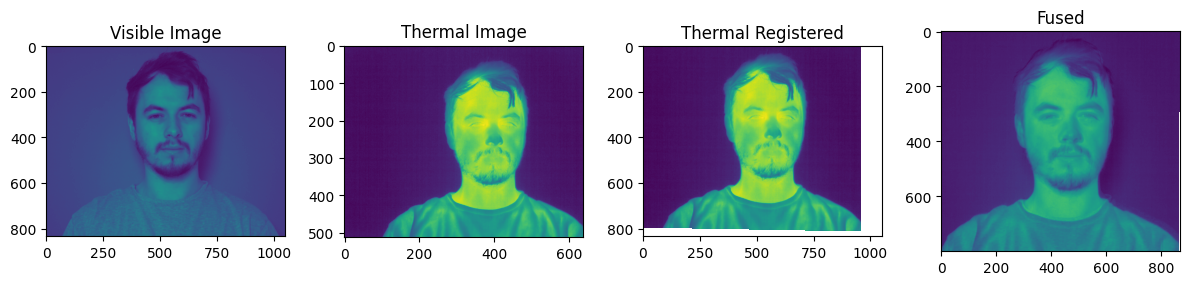

In [ ]:
import matplotlib.pyplot as plt



# thermal_np_masked = np.ma.masked_where(thermal_np == 0, thermal_np)  # Mask background

# thermal_norm = ((thermal_np_masked - thermal_np_masked.min()) / thermal_np_masked.ptp() * 255).astype(np.uint8)


# plt.imshow(thermal_norm)
# plt.title("Frame")
# # plt.axis('off')
# plt.show()
cropped = blended[0:800, 90:960]  # Crop the image to focus on the area of interest   
titles = ['Visible Image', 'Thermal Image', 'Thermal Registered', 'Fused']
images = [visible_np, thermal_frame, thermal_uint8, cropped]

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(images[i])
    plt.title(titles[i])
    # plt.axis('off')
plt.tight_layout()
plt.show()